In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from sklearn.preprocessing import MinMaxScaler

_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"

## Copy the plot generation code and adapt it to use the csv outputs scIB generates

In [2]:
def plot_results_table(df, min_max_scale: bool = True, show: bool = True, save_dir: str | None = None) -> Table:
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    save_dir
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    num_embeds = len(df.columns) - 1
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=mpl.cm.PRGn, num_stds=2.5)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    sort_col = "Total"
    plot_df = plot_df.sort_values(by=sort_col, ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    # Split columns by metric type, using df as it doesn't have the new method col
    score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]
    other_cols = df.columns[df.loc[_METRIC_TYPE] != _AGGREGATE_SCORE]
    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ]
    # Circles for the metric values
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group=df.loc[_METRIC_TYPE, col],
            formatter="{:.2f}",
        )
        for i, col in enumerate(other_cols)
    ]
    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": mpl.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with mpl.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        fig.savefig(f"scib_results_{save_dir}.svg", facecolor=ax.get_facecolor(), dpi=300)

    return tab

## Run it for different datasets

### Heart

In [41]:
df1 = pd.read_csv('results_heart/scib_results_disease_aug24/min_max_scale_f_/scib_results.csv', index_col=0)
df1 = df1.drop(columns=['X_fastmnn', 'X_scVI', 'X_scanorama', 'X_combat_pca', 'X_harmony', 'Metric Type']) # remove fastmnn, scvi and scanorama, combat, harmony
## second run with recently tested methods
df2 = pd.read_csv('results_heart/scib_results_disease_sep24/min_max_scale_f_/scib_results.csv', index_col=0)
df2 = df2.drop(columns=['X_scVI', 'X_pca', 'X_scmerge_pca', 'Metric Type']) # leave scdisinfect only
# third run with previously problematic methods
df3 = pd.read_csv('results_heart/scib_results_disease_oct24/min_max_scale_f_/scib_results.csv', index_col=0)


In [42]:
df = pd.concat([df1, df2, df3], axis=1)

In [43]:
df

,X_FinVAE,X_scpoli,X_scdisinfact,X_scanorama,X_scmerge2_pca,X_harmony,X_combat_pca,X_pca,X_scVI,X_fastmnn,Metric Type
Isolated labels,0.536252,0.495754,0.498722,0.499607,0.488074,0.477315,0.491934,0.481345,0.498507,0.499130,Bio conservation
KMeans NMI,0.515044,0.015802,0.000005,0.000010,0.023808,0.023376,0.021964,0.023655,0.022630,0.046728,Bio conservation
KMeans ARI,0.453011,0.005386,0.000381,0.000157,0.007808,0.007876,0.007853,0.007746,0.008283,0.035452,Bio conservation
Silhouette label,0.553900,0.485553,0.499647,0.499576,0.495852,0.488014,0.499739,0.495589,0.494925,0.490465,Bio conservation
cLISI,0.973063,0.554010,0.339415,0.348725,0.729513,0.435362,0.844465,0.847269,0.615214,1.000000,Bio conservation
Silhouette batch,0.942010,0.945788,0.995949,0.993128,0.933347,0.910134,0.962365,0.919232,0.971454,0.483161,Batch correction
iLISI,0.087120,0.200722,0.353042,0.334680,0.174573,0.260797,0.079651,0.087565,0.155820,0.000000,Batch correction
KBET,0.100195,0.128818,0.945857,0.948837,0.236128,0.383802,0.069546,0.095559,0.151578,0.000000,Batch correction
Graph connectivity,0.960171,0.775589,0.667726,0.484517,0.568360,0.642965,0.735931,0.698103,0.780177,0.114815,Batch correction
PCR comparison,0.000000,0.404466,0.999235,0.998732,0.281182,0.379536,0.999852,0.000000,0.320405,0.000000,Batch correction


In [44]:
df = df.transpose()

In [45]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
X_FinVAE,0.536252,0.515044,0.453011,0.5539,0.973063,0.94201,0.08712,0.100195,0.960171,0.0,0.417899,0.606254,0.530912
X_scpoli,0.495754,0.015802,0.005386,0.485553,0.55401,0.945788,0.200722,0.128818,0.775589,0.404466,0.491077,0.311301,0.383211
X_scdisinfact,0.498722,0.000005,0.000381,0.499647,0.339415,0.995949,0.353042,0.945857,0.667726,0.999235,0.792362,0.267634,0.477525
X_scanorama,0.499607,0.00001,0.000157,0.499576,0.348725,0.993128,0.33468,0.948837,0.484517,0.998732,0.751979,0.269615,0.46256
X_scmerge2_pca,0.488074,0.023808,0.007808,0.495852,0.729513,0.933347,0.174573,0.236128,0.56836,0.281182,0.438718,0.349011,0.384894
X_harmony,0.477315,0.023376,0.007876,0.488014,0.435362,0.910134,0.260797,0.383802,0.642965,0.379536,0.515447,0.286389,0.378012
X_combat_pca,0.491934,0.021964,0.007853,0.499739,0.844465,0.962365,0.079651,0.069546,0.735931,0.999852,0.569469,0.373191,0.451702
X_pca,0.481345,0.023655,0.007746,0.495589,0.847269,0.919232,0.087565,0.095559,0.698103,0.0,0.360092,0.371121,0.366709
X_scVI,0.498507,0.02263,0.008283,0.494925,0.615214,0.971454,0.15582,0.151578,0.780177,0.320405,0.475887,0.327912,0.387102
X_fastmnn,0.49913,0.046728,0.035452,0.490465,1.0,0.483161,0.0,0.0,0.114815,0.0,0.119595,0.414355,0.296451


In [46]:
df = df.drop(columns=["KBET", "iLISI", "PCR comparison"])

In [47]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Batch correction,Bio conservation,Total
X_FinVAE,0.536252,0.515044,0.453011,0.5539,0.973063,0.94201,0.960171,0.417899,0.606254,0.530912
X_scpoli,0.495754,0.015802,0.005386,0.485553,0.55401,0.945788,0.775589,0.491077,0.311301,0.383211
X_scdisinfact,0.498722,0.000005,0.000381,0.499647,0.339415,0.995949,0.667726,0.792362,0.267634,0.477525
X_scanorama,0.499607,0.00001,0.000157,0.499576,0.348725,0.993128,0.484517,0.751979,0.269615,0.46256
X_scmerge2_pca,0.488074,0.023808,0.007808,0.495852,0.729513,0.933347,0.56836,0.438718,0.349011,0.384894
X_harmony,0.477315,0.023376,0.007876,0.488014,0.435362,0.910134,0.642965,0.515447,0.286389,0.378012
X_combat_pca,0.491934,0.021964,0.007853,0.499739,0.844465,0.962365,0.735931,0.569469,0.373191,0.451702
X_pca,0.481345,0.023655,0.007746,0.495589,0.847269,0.919232,0.698103,0.360092,0.371121,0.366709
X_scVI,0.498507,0.02263,0.008283,0.494925,0.615214,0.971454,0.780177,0.475887,0.327912,0.387102
X_fastmnn,0.49913,0.046728,0.035452,0.490465,1.0,0.483161,0.114815,0.119595,0.414355,0.296451


In [48]:
metrics_bio = [i for i in df.columns if df[i][-1] == 'Bio conservation']

/tmp/ipykernel_1546250/1643923514.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics_bio = [i for i in df.columns if df[i][-1] == 'Bio conservation']


In [49]:
metrics_batch = [i for i in df.columns if df[i][-1] == 'Batch correction']

/tmp/ipykernel_1546250/3576803547.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics_batch = [i for i in df.columns if df[i][-1] == 'Batch correction']


In [50]:
metrics_bio

['Isolated labels', 'KMeans NMI', 'KMeans ARI', 'Silhouette label', 'cLISI']

In [51]:
metrics_batch

['Silhouette batch', 'Graph connectivity']

In [52]:
df.index

Index(['X_FinVAE', 'X_scpoli', 'X_scdisinfact', 'X_scanorama',
       'X_scmerge2_pca', 'X_harmony', 'X_combat_pca', 'X_pca', 'X_scVI',
       'X_fastmnn', 'Metric Type'],
      dtype='object')

In [53]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Batch correction,Bio conservation,Total
X_FinVAE,0.536252,0.515044,0.453011,0.5539,0.973063,0.94201,0.960171,0.417899,0.606254,0.530912
X_scpoli,0.495754,0.015802,0.005386,0.485553,0.55401,0.945788,0.775589,0.491077,0.311301,0.383211
X_scdisinfact,0.498722,0.000005,0.000381,0.499647,0.339415,0.995949,0.667726,0.792362,0.267634,0.477525
X_scanorama,0.499607,0.00001,0.000157,0.499576,0.348725,0.993128,0.484517,0.751979,0.269615,0.46256
X_scmerge2_pca,0.488074,0.023808,0.007808,0.495852,0.729513,0.933347,0.56836,0.438718,0.349011,0.384894
X_harmony,0.477315,0.023376,0.007876,0.488014,0.435362,0.910134,0.642965,0.515447,0.286389,0.378012
X_combat_pca,0.491934,0.021964,0.007853,0.499739,0.844465,0.962365,0.735931,0.569469,0.373191,0.451702
X_pca,0.481345,0.023655,0.007746,0.495589,0.847269,0.919232,0.698103,0.360092,0.371121,0.366709
X_scVI,0.498507,0.02263,0.008283,0.494925,0.615214,0.971454,0.780177,0.475887,0.327912,0.387102
X_fastmnn,0.49913,0.046728,0.035452,0.490465,1.0,0.483161,0.114815,0.119595,0.414355,0.296451


In [54]:
for method in df.index[:-1]:
    df.at[method, 'Batch correction'] = df.loc[method, metrics_batch].mean()
    df.at[method, 'Total'] = df.at[method, 'Batch correction'] * 0.4 + df.at[method, 'Bio conservation'] * 0.6

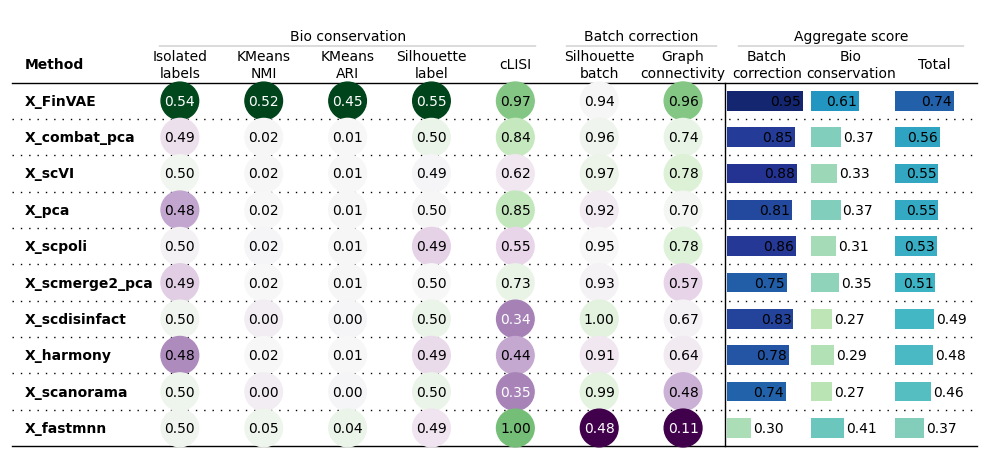

In [55]:
# Plot the results
plot_results_table(df, min_max_scale=True, show=True, save_dir='heart')

### Lung

In [56]:
# Save this script as plot_from_csv.py

# Path to the CSV file generated from get_results
df1 = pd.read_csv('results_lung/scib_results_newcelltype_stage/min_max_scale_f_/scib_results.csv', index_col=0)
df1 = df1.drop(columns=['Metric Type'])
df2 = pd.read_csv('results_lung/invae/scib_results_newcelltype_stage/min_max_scale_f_/scib_results.csv', index_col=0)
df2.columns = ['X_FinVAE', 'Metric Type']

In [57]:
df = pd.concat([df1, df2], axis=1)

In [58]:
df = df.transpose()

In [59]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
X_pca,0.480942,0.662662,0.081976,0.472474,0.998459,0.883896,0.089067,0.690736,0.646769,0.0,0.462093,0.539303,0.508419
X_scVI,0.47116,0.564316,0.03807,0.452064,0.99658,0.895323,0.217465,0.765518,0.626824,0.674966,0.636019,0.504438,0.55707
X_combat_pca,0.500503,0.67144,0.082078,0.476455,0.998648,0.732913,0.057843,0.378459,0.734783,0.999872,0.580774,0.545825,0.559804
X_scpoli,0.450717,0.630152,0.065629,0.440612,0.997651,0.833264,0.143424,0.666728,0.58527,0.0,0.445737,0.516952,0.488466
X_FinVAE,0.481643,0.649589,0.071443,0.466899,0.998335,0.879483,0.088219,0.661908,0.700099,0.210033,0.507948,0.533582,0.523328
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [60]:
df = df.drop(columns=["KBET", "iLISI", "PCR comparison"])

In [61]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Batch correction,Bio conservation,Total
X_pca,0.480942,0.662662,0.081976,0.472474,0.998459,0.883896,0.646769,0.462093,0.539303,0.508419
X_scVI,0.47116,0.564316,0.03807,0.452064,0.99658,0.895323,0.626824,0.636019,0.504438,0.55707
X_combat_pca,0.500503,0.67144,0.082078,0.476455,0.998648,0.732913,0.734783,0.580774,0.545825,0.559804
X_scpoli,0.450717,0.630152,0.065629,0.440612,0.997651,0.833264,0.58527,0.445737,0.516952,0.488466
X_FinVAE,0.481643,0.649589,0.071443,0.466899,0.998335,0.879483,0.700099,0.507948,0.533582,0.523328
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [62]:
metrics_bio = [i for i in df.columns if df[i][-1] == 'Bio conservation']

/tmp/ipykernel_1546250/1643923514.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics_bio = [i for i in df.columns if df[i][-1] == 'Bio conservation']


In [63]:
metrics_batch = [i for i in df.columns if df[i][-1] == 'Batch correction']

/tmp/ipykernel_1546250/3576803547.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics_batch = [i for i in df.columns if df[i][-1] == 'Batch correction']


In [64]:
metrics_bio

['Isolated labels', 'KMeans NMI', 'KMeans ARI', 'Silhouette label', 'cLISI']

In [65]:
metrics_batch

['Silhouette batch', 'Graph connectivity']

In [66]:
df.index

Index(['X_pca', 'X_scVI', 'X_combat_pca', 'X_scpoli', 'X_FinVAE',
       'Metric Type'],
      dtype='object')

In [67]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Batch correction,Bio conservation,Total
X_pca,0.480942,0.662662,0.081976,0.472474,0.998459,0.883896,0.646769,0.462093,0.539303,0.508419
X_scVI,0.47116,0.564316,0.03807,0.452064,0.99658,0.895323,0.626824,0.636019,0.504438,0.55707
X_combat_pca,0.500503,0.67144,0.082078,0.476455,0.998648,0.732913,0.734783,0.580774,0.545825,0.559804
X_scpoli,0.450717,0.630152,0.065629,0.440612,0.997651,0.833264,0.58527,0.445737,0.516952,0.488466
X_FinVAE,0.481643,0.649589,0.071443,0.466899,0.998335,0.879483,0.700099,0.507948,0.533582,0.523328
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [68]:
for method in df.index[:-1]:
    df.at[method, 'Batch correction'] = df.loc[method, metrics_batch].mean()
    df.at[method, 'Total'] = df.at[method, 'Batch correction'] * 0.4 + df.at[method, 'Bio conservation'] * 0.6

In [69]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,Graph connectivity,Batch correction,Bio conservation,Total
X_pca,0.480942,0.662662,0.081976,0.472474,0.998459,0.883896,0.646769,0.765333,0.539303,0.629715
X_scVI,0.47116,0.564316,0.03807,0.452064,0.99658,0.895323,0.626824,0.761073,0.504438,0.607092
X_combat_pca,0.500503,0.67144,0.082078,0.476455,0.998648,0.732913,0.734783,0.733848,0.545825,0.621034
X_scpoli,0.450717,0.630152,0.065629,0.440612,0.997651,0.833264,0.58527,0.709267,0.516952,0.593878
X_FinVAE,0.481643,0.649589,0.071443,0.466899,0.998335,0.879483,0.700099,0.789791,0.533582,0.636065
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


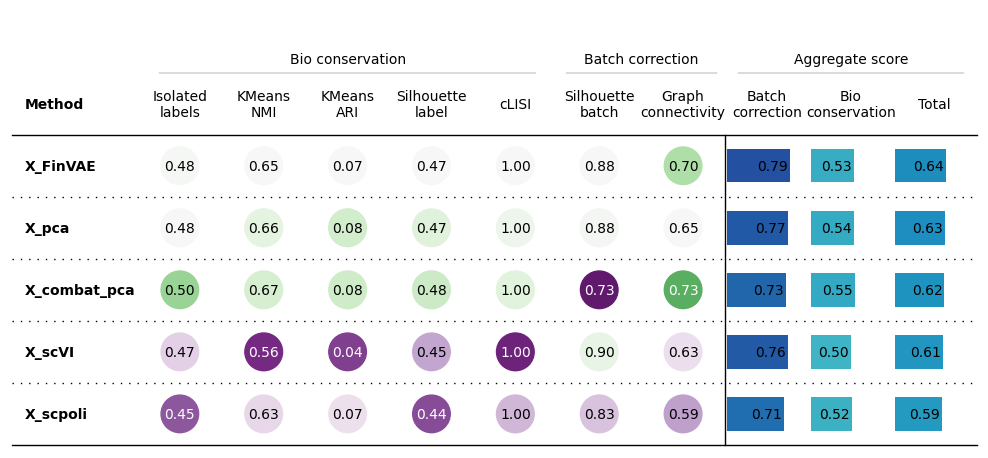

In [70]:
# Plot the results
plot_results_table(df, min_max_scale=True, show=True, save_dir='lung')